딥 러닝 (심층 학습)
=============

과제 1
------------

이 과제의 목적은 간단한 데이터를 다루는 법을 배우고, 앞으로 우리가 자주 사용할 데이터와 친숙해지는 것입니다.

이 노트북은 [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) 데이터셋과 파이썬을 사용합니다. 이 데이터셋은 고전적인 [MNIST](http://yann.lecun.com/exdb/mnist/) 데이터셋과 비슷하게 구성되었지만 실제 데이터에 더욱 가깝습니다. 다루기 어렵고, 데이터가 MNIST보다 덜 깔끔합니다.

In [1]:
# 앞으로 우리가 사용할 모듈들입니다.
# 더 진행하기 전에 문제없이 import할 수 있는지 반드시 확인하세요.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# matplotlib 뒷단을 IPython에서 인라인으로 그림을 그릴 수 있게 설정합니다.
%matplotlib inline
print('역자 주: 이 문장이 보이면 잘 된 것입니다.')

역자 주: 이 문장이 보이면 잘 된 것입니다.


먼저 개인 컴퓨터로 데이터셋을 다운받습니다. 다양한 글꼴로 구성된 글자들이 28x28 크기의 이미지로 저장되어 있습니다. 라벨은 A부터 J까지 총 10개 밖에 없습니다. 훈련 셋에는 약 50만 글자가, 테스트 셋에는 19000개의 라벨이 달린 글자가 들어 있습니다. 데이터셋 크기가 크지 않기 때문에, 어느 컴퓨터에서나 빠르게 모델을 훈련할 수 있을 것입니다.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # 다른 곳에 저장하고 싶으면 이 값을 바꿔주세요.

def download_progress_hook(count, blockSize, totalSize):
  """
  다운로드 진행 상황을 보고하기 위한 훅입니다. 이것은 주로 인터넷이 느린 사용자들을 위한 함수입니다.
  진행률이 5% 바뀔 때마다 업데이트됩니다.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """파일이 없으면 다운로드하고, 파일 크기가 올바른지 확인합니다."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('다운로드 시도: ', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\n다운로드 완료!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('파일 찾기 및 검사 완료: ', dest_filename)
  else:
    raise Exception(
      '파일 검사 실패: ' + dest_filename + '. 웹 브라우저로 접근 가능한 파일인가요?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

파일 찾기 및 검사 완료:  ./notMNIST_large.tar.gz
파일 찾기 및 검사 완료:  ./notMNIST_small.tar.gz


.tar.gz 압축 파일에서 데이터셋을 추출합니다.
이 작업이 끝나면 A부터 J까지의 디렉토리가 생성될 것입니다.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # .tar.gz 파일 삭제
  if os.path.isdir(root) and not force:
    # force=True 로 설정을 덮어쓸 수 있습니다.
    print('%s 이미 존재 - %s 파일의 압축 해제를 건너뜁니다.' % (root, filename))
  else:
    print('%s 에서 압축 해제. 시간이 좀 걸릴 수 있습니다. 기다려 주세요.' % root)
    print('(역자 주: 진짜로 꽤 오래 걸립니다.)')
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      '클래스 당 하나씩 %d 개의 디렉토리가 있어야 하는데 %d 개 밖에 없습니다.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large 에서 압축 해제. 시간이 좀 걸릴 수 있습니다. 기다려 주세요.
(역자 주: 진짜로 꽤 오래 걸립니다.)
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small 에서 압축 해제. 시간이 좀 걸릴 수 있습니다. 기다려 주세요.
(역자 주: 진짜로 꽤 오래 걸립니다.)
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
문제 1
------

데이터가 정상적인지 살짝 살펴보겠습니다. 각각의 그림 파일에는 A부터 J까지의 글자가 서로 다른 글꼴로 쓰여 있어야 합니다. 방금 다운로드받은 그림 파일의 샘플을 표시해보세요. (도움말: IPython.display 패키지를 사용해보세요.)

---

역자 개인 풀이 1
---------------

저는 다음과 같은 방식으로 글자 하나를 출력해 보았습니다.

In [4]:
# 역자 주: 저는 이렇게 글자 하나를 출력해 보았습니다.
display(Image(filename=os.path.join(data_root, "notMNIST_large", "A", "a2F6b28udHRm.png")))

---

이제 데이터를 활용하기 편한 형태로 바꿔보도록 하겠습니다. 여러분의 컴퓨터 사양에 따라 모든 데이터를 메모리에 올릴 수 없을 수도 있기 때문에, 각각의 항목을 별도의 데이터셋으로 만들어서 디스크에 저장하고 따로따로 다루도록 하겠습니다. 추후에 우리가 관리할 수 있는 크기의 하나의 데이터셋으로 합치게 될 것입니다.

학습을 용이하게 하기 위해서 전체 데이터셋을 부동 소수점 형식의 3차원 배열(그림 파일 번호, x, y)로 만든 뒤 평균이 거의 0이 되고 표준편차가 0.5에 가깝게 되도록 변환하겠습니다.

몇몇 그림 파일을 읽을 수 없을 수도 있는데, 그냥 건너뛰면 됩니다.

In [5]:
image_size = 28  # 그림 파일의 가로와 세로 픽셀 값입니다.
pixel_depth = 255.0  # 픽셀 하나가 가질 수 있는 레벨의 개수입니다.

def load_letter(folder, min_num_images):
  """하나의 글자 라벨에 대한 데이터를 불러옵니다."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('예상치 못했던 모양의 그림 파일입니다: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('읽을 수 없는 파일:', image_file, ':', e, '- 괜찮습니다. 그냥 넘어갑시다.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('생각했던 것보다 그림 파일이 너무 적습니다: %d < %d' %
                    (num_images, min_num_images))
    
  print('전체 데이터셋 텐서:', dataset.shape)
  print('평균:', np.mean(dataset))
  print('표준편차:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  print("역자 주: 피클이라는 모듈을 사용해서 데이터를 관리하고 있습니다.")
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # force=True로 설정을 덮어쓸 수 있습니다.
      print('%s 이 이미 존재합니다 - 개별 피클 데이터셋 작성을 중지합니다.' % set_filename)      
    else:
      print('개별 피클 데이터셋 작성: %s' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('다음 파일명으로 저장할 수 없습니다:', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

역자 주: 피클이라는 모듈을 사용해서 데이터를 관리하고 있습니다.
개별 피클 데이터셋 작성: ./notMNIST_large/A.pickle
./notMNIST_large/A
읽을 수 없는 파일: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - 괜찮습니다. 그냥 넘어갑시다.
읽을 수 없는 파일: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - 괜찮습니다. 그냥 넘어갑시다.
읽을 수 없는 파일: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - 괜찮습니다. 그냥 넘어갑시다.
전체 데이터셋 텐서: (52909, 28, 28)
평균: -0.12825
표준편차: 0.443121
개별 피클 데이터셋 작성: ./notMNIST_large/B.pickle
./notMNIST_large/B
읽을 수 없는 파일: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - 괜찮습니다. 그냥 넘어갑시다.
전체 데이터셋 텐서: (52911, 28, 28)
평균: -0.00756304
표준편차: 0.454491
개별 피클 데이터셋 작성: ./notMNIST_large/

---
문제 2
------

데이터가 여전히 상태가 괜찮은지 확인해봅시다. ndarray에서 샘플 라벨과 샘플 그림 파일을 출력해보세요. (도움말: matplotlib.pyplot을 사용해보세요.)

---

역자 개인 풀이 2
---------------
저는 J에 해당하는 피클 파일을 열어서 그림 파일의 개수, 세로 픽셀 수, 가로 픽셀 수를 출력해본 뒤 35번째 그림을 화면에 나타내 보았습니다.

J에 대한 그림 파일 개수: 52911
J에 대한 그림 파일의 세로 픽셀 수: 28
J에 대한 그림 파일의 가로 픽셀 수: 28
--------------------------------
35번째 글꼴이 맘에 들어서 그것을 출력해 보았습니다.


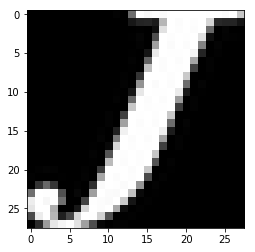

In [6]:
# 역자 주: 저는 이렇게 풀었습니다.

f = open(train_datasets[9], "rb") # J에 해당하는 파일 열기
jDataset = pickle.load(f) # 피클 데이터셋 불러오기
print("J에 대한 그림 파일 개수: " + str(len(jDataset)))
print("J에 대한 그림 파일의 세로 픽셀 수: " + str(len(jDataset[0])))
print("J에 대한 그림 파일의 가로 픽셀 수: " + str(len(jDataset[0][0])))
print("--------------------------------")
print("35번째 글꼴이 맘에 들어서 그것을 출력해 보았습니다.")
oneImage = jDataset[34] * pixel_depth + (pixel_depth/2) # 정규화 되돌리기
imgplot = plt.imshow(oneImage)
imgplot.set_cmap('gray') # 이걸 안 하면 자기 맘대로 색깔이 들어갑니다.
f.close()

---
문제 3
------
검사할 것이 하나 더 있습니다. 서로 다른 클래스 간의 데이터가 균형이 맞아 있었으면 합니다. 확인해 보세요.

(역자 주: 클래스 별로 데이터 개수가 비슷해야 한다는 뜻 같습니다.)

---

역자 개인 풀이 3
---------------

저는 각 클래스에 있는 그림 파일 개수를 다 출력해 보았습니다. 이 정도면 균형이 잘 맞아 보입니다.

In [7]:
# 역자 주: 저는 각 클래스에 있는 그림 파일 개수를 다 출력해보는 방식으로 풀었습니다.

alphabetList = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
numMin = 1000000 # 엄밀하게 하시려면 sys.maxsize를 쓰셔도 됩니다.
numMax = 0

for i in range(0, 10): # A부터 J까지 10개의 글자가 있기 때문에 range(0, 10)을 사용했습니다.
  f = open(train_datasets[i], "rb")
  onePickle = pickle.load(f)
  numFiles = len(onePickle)
  if numMax < numFiles:
    numMax = numFiles
  if numMin > numFiles:
    numMin = numFiles
  print(alphabetList[i] + " 그림 개수: " + str(numFiles))
  f.close()
    
print("각 클래스 당 그림 파일 개수: " + str(numMin) + "개 ~ " + str(numMax) + "개")
print("이 정도면 균형이 잘 맞아 보입니다.")

A 그림 개수: 52909
B 그림 개수: 52911
C 그림 개수: 52912
D 그림 개수: 52911
E 그림 개수: 52912
F 그림 개수: 52912
G 그림 개수: 52912
H 그림 개수: 52912
I 그림 개수: 52912
J 그림 개수: 52911
각 클래스 당 그림 파일 개수: 52909개 ~ 52912개
이 정도면 균형이 잘 맞아 보입니다.


---
훈련 데이터를 필요에 따라 합치고 다듬어 보세요. 여러분의 컴퓨터 설정에 따라 모든 데이터를 한 번에 메모리에 올릴 수 없을지도 모르는데, 그럴 경우 `train size` 값을 조절하시면 됩니다. 라벨들은 정수값 0부터 9에 걸쳐 서로 분리된 배열에 저장됩니다.

또 하이퍼파라미터 조절을 위한 검증 데이터셋(밸리데이션 데이터셋)을 만들어 보세요.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # 글자들을 섞어서 무작위로 검증 데이터셋과 훈련 데이터셋을 만들겠습니다.
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('다음 피클 파일에서 데이터를 추출할 수 없습니다: ', pickle_file, '. 에러 메시지: ', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('훈련용  :', train_dataset.shape, train_labels.shape)
print('검증용  :', valid_dataset.shape, valid_labels.shape)
print('테스트용:', test_dataset.shape, test_labels.shape)

훈련용  : (200000, 28, 28) (200000,)
검증용  : (10000, 28, 28) (10000,)
테스트용: (10000, 28, 28) (10000,)


다음으로는 데이터를 무작위로 섞겠습니다. 훈련용과 테스트용의 라벨 분포가 균일하도록 잘 섞는 것이 매우 중요합니다.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
문제 4
------
섞은 후에도 데이터 상태가 여전히 좋다는 것을 스스로 확인해보세요!

역자 개인 풀이 4
----------------

섞인 데이터의 라벨 분포를 출력해 보았습니다. 아주 고르게 잘 섞여 있습니다.

In [10]:
# 역자 주: 섞인 데이터의 라벨 분포를 출력해 보았습니다.
print("위에서부터 순서대로 훈련 데이터, 검증 데이터, 테스트 데이터입니다.")
print("------------------------------------------------------------------")
for labels in [train_labels, valid_labels, test_labels]:  
  for i in range(0, 10): # A부터 J까지 10개의 글자가 있기 때문에 range(0, 10)을 사용했습니다.
    count_such_label = [1 if x == i else 0 for x in labels]
    print(alphabetList[i] + " 라벨 개수: " + str(sum(count_such_label)))
  print("--------------------------")
print("아주 고르게 잘 섞인 것을 확인했습니다.")

위에서부터 순서대로 훈련 데이터, 검증 데이터, 테스트 데이터입니다.
------------------------------------------------------------------
A 라벨 개수: 20000
B 라벨 개수: 20000
C 라벨 개수: 20000
D 라벨 개수: 20000
E 라벨 개수: 20000
F 라벨 개수: 20000
G 라벨 개수: 20000
H 라벨 개수: 20000
I 라벨 개수: 20000
J 라벨 개수: 20000
--------------------------
A 라벨 개수: 1000
B 라벨 개수: 1000
C 라벨 개수: 1000
D 라벨 개수: 1000
E 라벨 개수: 1000
F 라벨 개수: 1000
G 라벨 개수: 1000
H 라벨 개수: 1000
I 라벨 개수: 1000
J 라벨 개수: 1000
--------------------------
A 라벨 개수: 1000
B 라벨 개수: 1000
C 라벨 개수: 1000
D 라벨 개수: 1000
E 라벨 개수: 1000
F 라벨 개수: 1000
G 라벨 개수: 1000
H 라벨 개수: 1000
I 라벨 개수: 1000
J 라벨 개수: 1000
--------------------------
아주 고르게 잘 섞인 것을 확인했습니다.


---
마지막으로, 재사용이 가능하도록 데이터를 저장해봅시다.

In [11]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('다음 피클 파일에 저장할 수 없습니다: ', pickle_file, '. 에러 메시지:', e)
  raise

In [12]:
statinfo = os.stat(pickle_file)
print('압축된 피클 파일 크기:', statinfo.st_size)

압축된 피클 파일 크기: 690800506


---
문제 5
------

이 데이터셋은 애초에 중복된 샘플이 많을 수도 있게 설계되어서, 훈련 데이터셋에 있는 샘플이 검증 데이터셋과 테스트 데이터셋에 있을 수도 있습니다! 여러분이 여러분의 모델을 중복이 없는 환경에서 사용하기를 원한다면 이러한 훈련 셋과 테스트 셋 간의 중복은 예측 결과를 왜곡시킬 수 있습니다만, 여러분이 훈련에 사용한 데이터를 실제 상황에서 또 만나는 것을 예상하고 있다면 괜찮습니다. 훈련, 검증, 테스트 샘플이 얼마나 중복되어 있는지를 측정해 보세요.

추가 문제:
- 데이터셋 간에 거의 비슷한 정도는 어떠한가요? (거의 비슷한 그림들을 뜻합니다.)
- 깔끔한 검증 셋과 테스트 셋을 만들어서 앞으로의 과제에서 여러분 모델의 정확성을 측정할 때 사용하세요.
---

역자 개인 풀이 5
----------------

이렇게 풀었습니다.

In [27]:
# 계산량이 많은 작업이라 셀을 분리했습니다.
print("학습 데이터셋의 D 항목에 대해서만 연습삼아 해 보았습니다.")

trainD = list()
for i in range(0, len(train_labels)):
  if train_labels[i] == 3:
    trainD.append(train_dataset[i])

trainD = np.array(trainD) # numpy array로 변환

학습 데이터셋의 D 항목에 대해서만 연습삼아 해 보았습니다.


학습 데이터 중 D항목의 개수: 20000
예제 출력
중복을 제외하고 남은 D항목 이미지 개수: 1


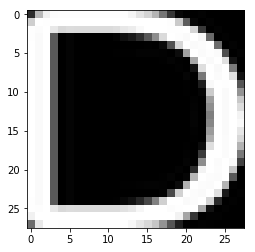

In [50]:
print("학습 데이터 중 D항목의 개수: " + str(len(trainD)))
print("예제 출력")
imageD = trainD[i] * pixel_depth + (pixel_depth/2) # 정규화 되돌리기
imgplotD = plt.imshow(imageD)
imgplotD.set_cmap('gray') # 이걸 안 하면 자기 맘대로 색깔이 들어갑니다.

countUnique = 1
# 중복 검사 작업 필요

print("중복을 제외하고 남은 D항목 이미지 개수: " + str(countUnique))

---
문제 6
------

즉석에서 사용 가능한 분류기가 이 데이터를 어떻게 분석할 수 있는지 봅시다. 무언가 배울 것이 있는지 확인해보는 것은 언제나 좋은 일이고, 사용 가능한 방법들로 이 문제를 풀기가 쉽지 않다는 것이 문제라는 것을 아는 것도 중요합니다.

이 데이터에서 50, 100, 1000, 5000개의 샘플을 사용해서 간단한 모델을 학습시켜 보세요. (도움말: sklearn.linear_model에 있는 로지스틱 회귀 함수를 사용해보세요.)

추가 문제: 전체 데이터에 대해서도 학습을 시켜 보세요!

---

역자 개인 풀이 6
----------------

이렇게 풀었습니다.

In [52]:
train_dataset_100 = train_dataset[0:100]
train_labels_100 = train_labels[0:100]
lr = LogisticRegression(random_state=1234) # 로지스틱 회귀 분석기 생성
#lr.fit(train_dataset_100, train_labels_100) # 학습 # 코드 짜는중입니다 -_-a